An accelerator with m-BPMS and n-correctors produces an m x n dimensional response matrix:
$$C_{mn}=\frac{\sqrt{\beta_m\beta_n}}{2\sin(\pi \nu)}\cos(\pi\nu -\phi(s)+\phi(s_0)) + \frac{\eta_i \eta_j}{\alpha_c L_o}$$
In LOCO the measured orbit response matrix ORM is fitted to the lattice model, to find the proper quadrpoles strengths.


In [1]:
import numpy as np
lattice_name = 'FCCee_z_566_nosol_4_bb'

arc_quads = np.load("arc_quads_new.npy") # load arc elements indices
arc_sext = np.load("arc_sext_new.npy")

dCx = np.load('dCx.npy') # Jacobian, calculated while sextupoles off
dCy = np.load('dCy.npy')
dCxy = np.load('dCxy.npy')
dCyx = np.load('dCyx.npy')

Rvx = np.load('Rvx.npy') # Inverse ORMs (all correctors used)
Rvy = np.load('Rvy.npy')
num_used_correctors = 10
correctors_kick = 1.e-7
dk = 1.e-6 # change in quads strengths

misaligned_elements = arc_quads
misaligned_elements2 = arc_sext

shiftx = 50.e-6 # Field and alignments error_values
shifty = 50.e-6
rots = 100.e-6 # Field and alignments error_values
#gradient_errors = 2.e-04

sigmaCut = 2.5 #sigma error cut
sCut = 1250 # singular value cut

# parameters for DA calculations
dr=0.5
dp=0.0
nturns=100
xp0=0.0
yp0=0.0
eh = 0.71e-9
ev =  1.4e-12

Load the lattice - radiation off


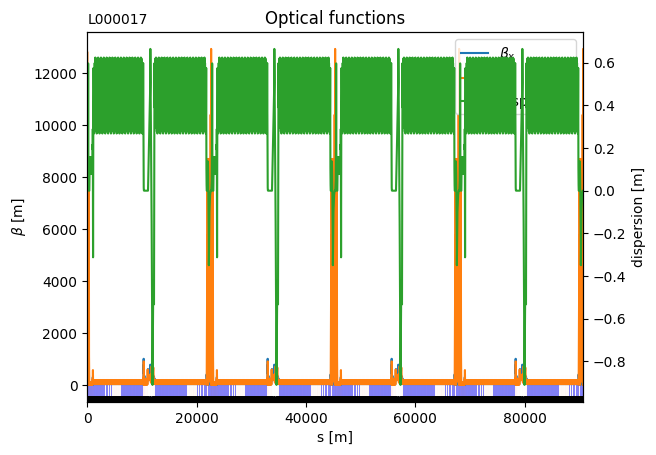

 Turn sext off 
 BPM_to_corrector_response_matrices (Model) ..
 Generate quadrupoles response (Jacobian) ..
The lattice FCCee_z_566_nosol_4_bb has 1876 BPMs, 1876 Correctors, 3064 Dipoles, and 1876 quadrupoles. Number of used correctors = 10
The ideal lattice tune values: [218.1584494  222.19880148], The chromaticity values: [ -538.59875827 -3636.29297063]. 
Dynamic Aperture calculation - nominal


In [2]:
print(f"Load the lattice - radiation off")
from at_modules_loco import *
ring = at.load_mat(lattice_name)
ring.radiation_off()
ring.plot_beta()

print("Dynamic Aperture calculation - nominal")
#x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'nominal_da',showPlot=True, debug=True)

# elements indices
quads_indices = get_refpts(ring,at.elements.Quadrupole)
bpm_indices = get_refpts(ring, at.elements.Monitor)
corrector_indices= get_refpts(ring , at.elements.Corrector)
dipole_indices = get_refpts(ring, elements.Dipole)
used_cor_indices = select_equally_spaced_elements(corrector_indices, num_used_correctors)
[elemdata0, beamdata, elemdata] = at.get_optics(ring, quads_indices)
twiss_q = elemdata
nominal_crom = get_chrom(ring)

print(' Turn sext off ')
sext_strengths = []
sext_indexes = get_refpts(ring,at.elements.Sextupole)
for i in sext_indexes:
    sext_strengths.append(ring[i].H)
    ring[i].H = 0.0

print(" BPM_to_corrector_response_matrices (Model) ..")
Cx0, Cxy0, Cy0, Cyx0 = ORMs(correctors_kick, ring,used_cor_indices)

print(" Generate quadrupoles response (Jacobian) ..") #NOTE: files pre-loaded, the execution of this function is time-consuming

#dCx, dCy, dCxy, dCyx = generatingQuadsResponse(ring,Cx0, Cxy0, Cy0, Cyx0 , correctors_kick,used_cor_indices, quads_indices, dk,debug=True)

[elemdata0, beamdata, elemdata] = at.get_optics(ring, bpm_indices)
twiss = elemdata

print('The lattice {} has {} BPMs, {} Correctors, {} Dipoles, and {} quadrupoles. Number of used correctors = {}'.format(lattice_name, len(bpm_indices), len(corrector_indices), len(dipole_indices), len(quads_indices), len(used_cor_indices)))
nominal_tune = get_tune(ring, get_integer=True)
quad_strengths = np.array([ring[ind].K for ind in quads_indices])

print(f"The ideal lattice tune values: {nominal_tune}, "
      f"The chromaticity values: {get_chrom(ring)}. ")

 Introduce errors .. 


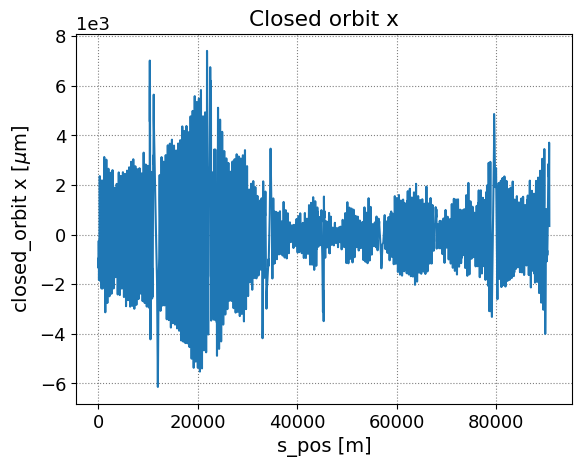

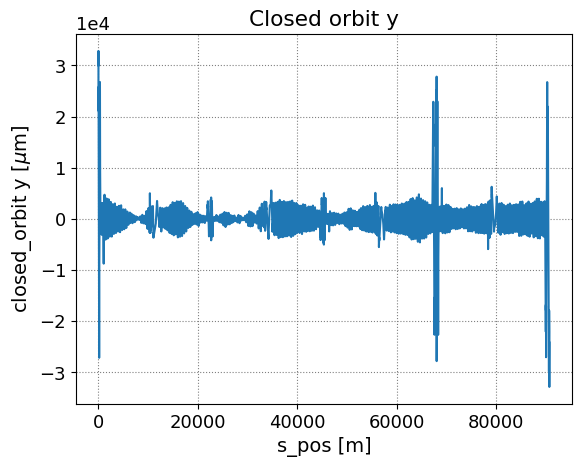

RMS horizontal orbit with errors: 1431.8739423287059 mu m,  RMS vertical orbit with errors: 4255.673863050604 mu m
Tune values with errors: [218.15827859 222.19896735], The chromaticity values: [ -551.67784239 -3623.1776592 ]. 
RMS horizontal beta beating:0.4131695910766029%   RMS vertical beta beating: 0.413095815251494%
Dynamic Aperture calculation - with errors


In [8]:
print(" Introduce errors .. ")

simulateShiftErrors(ring, shiftx,shifty, misaligned_elements, sigmaCut,  relative=True)
simulateShiftErrors(ring, shiftx,shifty, misaligned_elements2, sigmaCut,  relative=True)
simulateTilttErrors(ring, rots, misaligned_elements, sigmaCut, relative=True)
simulateTilttErrors(ring, rots, misaligned_elements2, sigmaCut, relative=True)
#simulateFieldErrors(ring, gradient_errors, misaligned_elements)
#simulateFieldErrors(ring, gradient_errors, misaligned_elements2)

[elemdata0, beamdata, elemdata] = at.get_optics(ring, bpm_indices)
twiss_err = elemdata
ring.save('{}_with_errors.mat'.format(lattice_name), mat_key='ring')
rmsx_err, rmsy_err = rms_orbits(ring, bpm_indices, makeplot = True)
print(f"RMS horizontal orbit with errors: {rmsx_err*1.e6} mu m, ", f"RMS vertical orbit with errors: {rmsy_err*1.e6} mu m")
print(f"Tune values with errors: {get_tune(ring, get_integer=True)}, "
      f"The chromaticity values: {get_chrom(ring)}. ")
bx_rms, by_rms = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
print("RMS horizontal beta beating:" + str(bx_rms * 100) + "%   RMS vertical beta beating: " + str(by_rms * 100) + "%")
print("Dynamic Aperture calculation - with errors")
#x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'with_errors',showPlot=True, debug=True)

# Orbit corrections

SVD orbit correction
RMS horizontal orbit with errors: 1431.8739423287059 mu m,  RMS vertical orbit with errors: 4255.673863050604 mu m
RMS horizontal orbit after correction: 34.665863437848195 mu m,  RMS vertical orbit after correction: 21.742940311892184 mu m
Tune values with orbit corrections: [218.15827859 222.19896729], The chromaticity values: [ -551.6779509  -3623.22566041]. 
RMS horizontal beta beating:0.4131722320836573%   RMS vertical beta beating: 0.41309490646248315%


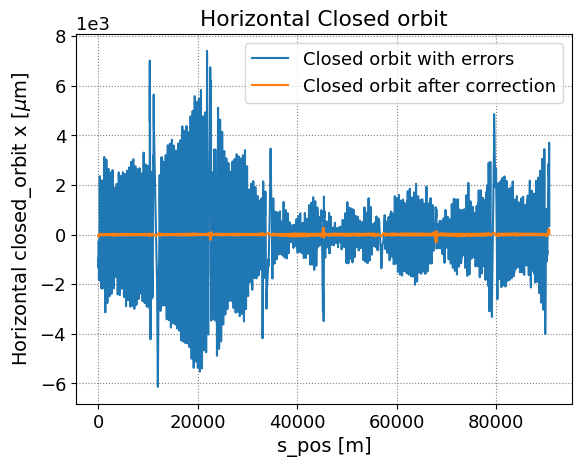

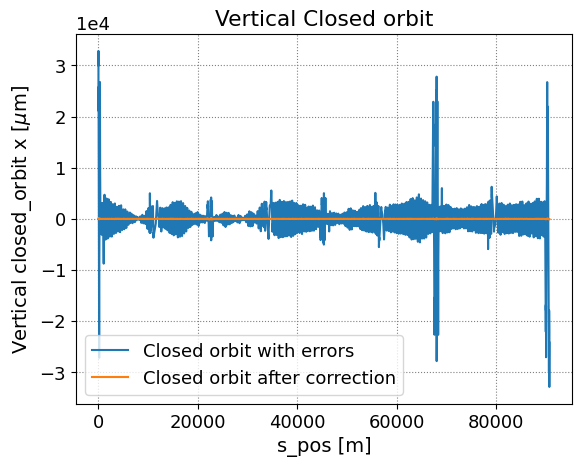

Dynamic Aperture calculation - orbit corrected


In [9]:
print('SVD orbit correction')
_, _, elemdata = at.get_optics(ring, bpm_indices)
closed_orbitx = elemdata.closed_orbit[:, 0]
closed_orbity = elemdata.closed_orbit[:, 2]
#Corrector_strength
CSx = np.dot(np.transpose(Rvx),-closed_orbitx)
CSy = np.dot(np.transpose(Rvy),-closed_orbity)
for m in range(len(corrector_indices)):
    ring[corrector_indices[m]].KickAngle  = [0,0]
    ring[corrector_indices[m]].KickAngle  = [CSx[m],CSy[m]]

ring.save('{}_orbit_corrected.mat'.format(lattice_name), mat_key='ring')
rmsx_cor, rmsy_cor = rms_orbits(ring, bpm_indices, makeplot = False)
bx_rms_err, by_rms_err = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
print(f"RMS horizontal orbit with errors: {rmsx_err*1.e6} mu m, ", f"RMS vertical orbit with errors: {rmsy_err*1.e6} mu m")
print(f"RMS horizontal orbit after correction: {rmsx_cor*1.e6} mu m, ", f"RMS vertical orbit after correction: {rmsy_cor*1.e6} mu m")
print(f"Tune values with orbit corrections: {get_tune(ring, get_integer=True)}, "
      f"The chromaticity values: {get_chrom(ring)}. ")
print("RMS horizontal beta beating:" + str(bx_rms_err * 100) + "%   RMS vertical beta beating: " + str(by_rms_err * 100) + "%")
corrections_plots(ring ,twiss, twiss_err, 'orbit')

# Swich sextupoles ON


In [10]:
print("Swich sextupoles ON")
for i in range(len(sext_indexes)):
    ring[sext_indexes[i]].H = sext_strengths[i]*1
rmsx, rmsy = rms_orbits(ring, bpm_indices, makeplot = False)
bx_rms_err, by_rms_err = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
print(f"RMS horizontal orbit with errors: {rmsx*1.e6} mu m, ", f"RMS vertical orbit with errors: {rmsy*1.e6} mu m")
print(f"RMS horizontal orbit after correction: {rmsx*1.e6} mu m, ", f"RMS vertical orbit after correction: {rmsy*1.e6} mu m")
print(f"Tune values with orbit corrections: {get_tune(ring, get_integer=True)}, "
      f"The chromaticity values: {get_chrom(ring)}. ")
print("RMS horizontal beta beating:" + str(bx_rms_err* 100) + "%   RMS vertical beta beating: " + str(by_rms_err* 100) + "%")
print("Dynamic Aperture calculation - orbit corrected")
#x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'orbit_corrected,showPlot=True, debug=True)
ring.save('{}_orbit_corrected_ext_ON.mat'.format(lattice_name), mat_key='ring')

Swich sextupoles ON
RMS horizontal orbit with errors: 38.11294170184058 mu m,  RMS vertical orbit with errors: 24.379619816957646 mu m
RMS horizontal orbit after correction: 38.11294170184058 mu m,  RMS vertical orbit after correction: 24.379619816957646 mu m
Tune values with orbit corrections: [218.15605343 222.19296595], The chromaticity values: [-0.07199176  5.04935002]. 
RMS horizontal beta beating:1.6418631979372496%   RMS vertical beta beating: 3.405368018112113%


# LOCO corrections


LOCO

Fitting Tune...
Initial value [218.15605343 222.19296595]
iter# 0 Res. 2.4205167563569675e-11
iter# 1 Res. 1.8235073487106163e-16
Final value [218.15844941 222.19880147] 


Fitting Chromaticity...
Initial value [-0.0749583   5.03423004]
iter# 0 Res. 1.345307351714152e-07
iter# 1 Res. 1.106192725216395e-07
iter# 2 Res. 1.8745727920727868e-08
Final value [0.03506473 5.00094094] 

 BPM_to_corrector_response_matrices (Measured) ..
LOCO iterations
Execution time: 754.5156400203705 sec


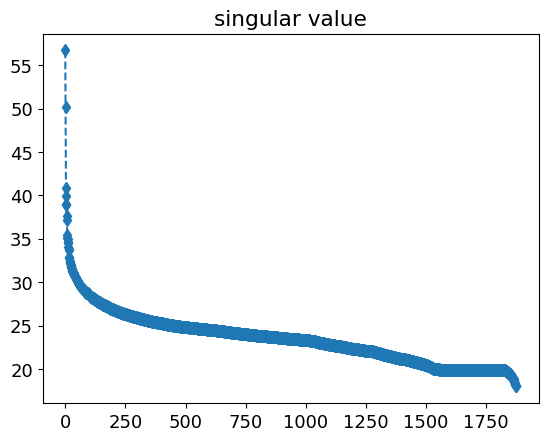

number of singular values 1876


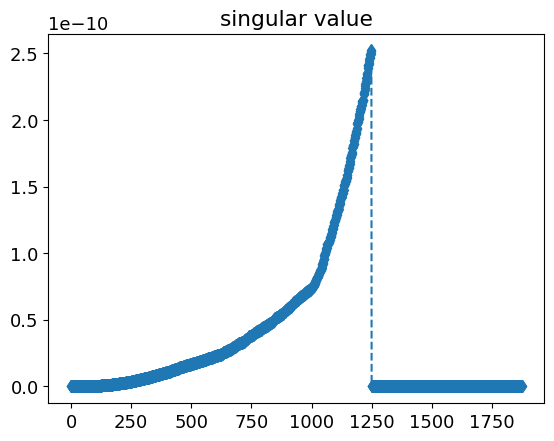

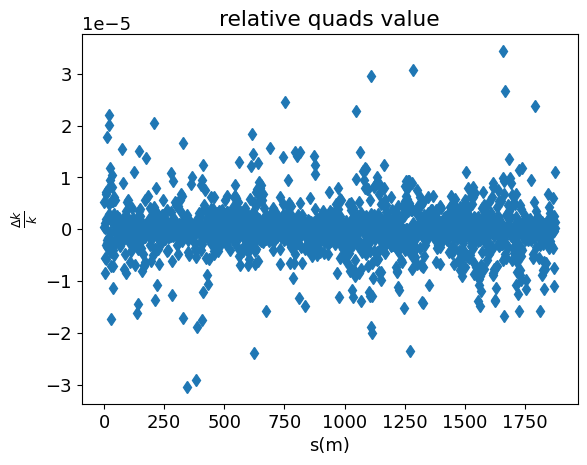

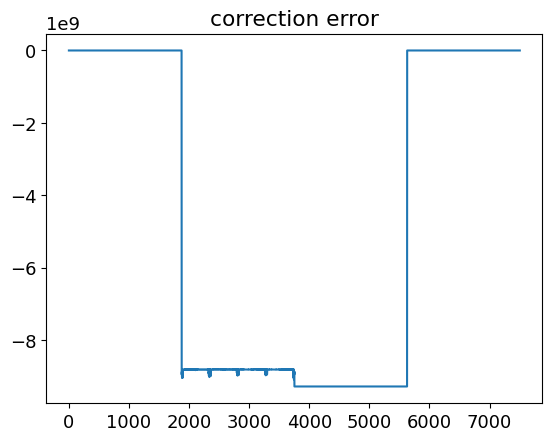

Beta beating before correction :
RMS horizontal beta beating:1.631260147614209%   RMS vertical beta beating: 3.3467111004065666%
Beta beating after corrections
RMS horizontal beta beating:1.780938596762049%   RMS vertical beta beating: 0.8696645646080369%
beta_x correction reduction -9.17563328980675
beta_x correction reduction 74.01435204543387
RMS horizontal orbit with optics correction: 40.182212922347865 mu m,  RMS vertical orbit with optics correction: 24.19683770639177 mu m
Tune values with optics corrections: [218.15949101 222.20355579], The chromaticity values: [0.05605118 4.15772561]. 


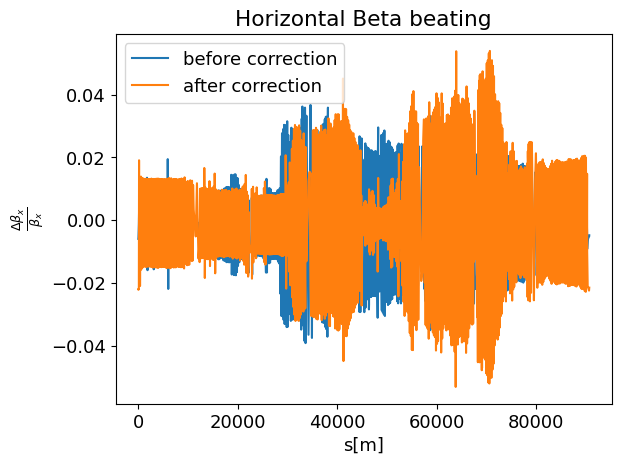

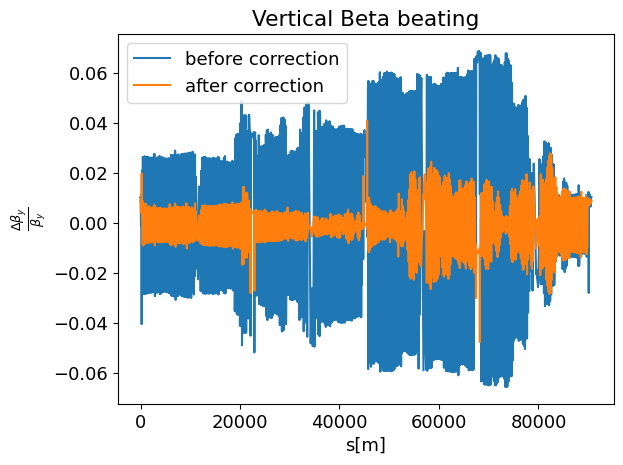

In [11]:
print('LOCO')
numberOfIteration = 1
for x in range(numberOfIteration):
    _, _, twiss_err = at.get_optics(ring, bpm_indices)
    fit_tune(ring, get_refpts(ring, 'QF*'),
    get_refpts(ring, 'QD*'),nominal_tune )
    fit_chrom(ring, get_refpts(ring, 'SF*'),
    get_refpts(ring, 'SD*'),nominal_crom)
    print(" BPM_to_corrector_response_matrices (Measured) ..")
    Cx, Cxy, Cy, Cyx = ORMs(correctors_kick, ring,used_cor_indices)
    bx_rms_err, by_rms_err = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
    print('LOCO iterations')
    t0 = time.time()
    A, B = defineJacobianMatrices(Cx0, Cy0, Cxy0, Cyx0, Cx, Cy, Cxy, Cyx, dCx, dCy, dCxy,dCyx)
    t1 = time.time()
    print(f"Execution time: {t1-t0} sec")
    np.save('A_{}.npy'.format(x), A)
    np.save('B_{}.npy'.format(x), B)
    Nk = len(dCx)
    r = getInverse(A, B, Nk, sCut, showPlots = 'True')
    setCorrection(ring, r , quads_indices)
    _, _, twiss_cor = at.get_optics(ring, bpm_indices)
    print('Beta beating before correction :')
    print("RMS horizontal beta beating:" + str(bx_rms_err * 100) + "%   RMS vertical beta beating: " + str(by_rms_err * 100) + "%")
    print('Beta beating after corrections')
    bx_rms_cor, by_rms_cor = getBetaBeat(ring, twiss, bpm_indices, makeplot = False)
    print("RMS horizontal beta beating:" + str(bx_rms_cor * 100) + "%   RMS vertical beta beating: " + str(by_rms_cor * 100) + "%")
    print('beta_x correction reduction', (1-bx_rms_cor/bx_rms_err)*100)
    print('beta_x correction reduction', (1-by_rms_cor/by_rms_err)*100)
    rmsx, rmsy = rms_orbits(ring, bpm_indices, makeplot = False)
    print(f"RMS horizontal orbit with optics correction: {rmsx*1.e6} mu m, ", f"RMS vertical orbit with optics correction: {rmsy*1.e6} mu m")
    print(f"Tune values with optics corrections: {get_tune(ring, get_integer=True)}, "
          f"The chromaticity values: {get_chrom(ring)}. ")
    corrections_plots(ring ,twiss, twiss_err, 'beta')
    ring.save('{}_Loco_corrected.mat'.format(x), mat_key='ring')


In [ ]:
print("Dynamic Aperture calculation - with LOCO correction")
x, y = dynamicAperture(ring, eh, ev, dr, dp, nturns, xp0, yp0,'with_correction',showPlot=True, debug=True)
ring.save('{}_with_errors.mat'.format(lattice_name), mat_key='ring')